Capacitated Vehecle Routing Problem

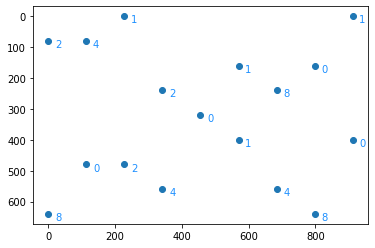

In [145]:
import matplotlib.pyplot as plt
import numpy as np

locations = [(456, 320), # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640)]  # location 16

orders = [0,    # 0 for depot
1,
1, 
2, 
4, 
1, #5
0, 
2, 
8, 
1, 
0, #10
0, 
2, 
4, 
4, 
8, #15
8]

x = list(map(lambda x: x[0], locations))
y = list(map(lambda x: x[1], locations))

plt.plot(x, y, 'o')
plt.gca().invert_yaxis()

for i in range (len(orders)):
    plt.text(locations[i][0]+20, locations[i][1]+20, orders[i], c='dodgerblue')

plt.show()

In [146]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # geek -> 임의의 위치에서 시작하게 하려면 depot->node로의 거리를 0으로 두면 된다.
    # but node->depot은 거리 적용해줘야 함!!
    
    temp_locations = []
    temp_orders = []

    for i in range (len(orders)):
        if (i!=0 and orders[i] == 0):
            continue
        else:
            temp_locations.append(locations[i])
            temp_orders.append(orders[i])

    data['distance_matrix'] = [[abs(temp_locations[i][0]-temp_locations[j][0])+abs(temp_locations[i][1]-temp_locations[j][1]) for j in range(len(temp_locations))] for i in range(len(temp_locations))]
    data['distance_matrix'][0] = [0 for i in range(len(temp_locations))]
    data['orders'] = temp_orders
    
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [100 for i in range(data['num_vehicles'])]
    data['depot'] = 0
    return data

In [147]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_order = 0
        index = solution.Value(routing.NextVar(index))

        root_arr_x = []
        root_arr_y = []

        while not routing.IsEnd(index):
            root_arr_x.append(locations[manager.IndexToNode(index)][0])
            root_arr_y.append(locations[manager.IndexToNode(index)][1])
            plt.text(locations[manager.IndexToNode(index)][0], locations[manager.IndexToNode(index)][1], index)

            node_index = manager.IndexToNode(index)
            route_order += data['orders'][node_index]
            plt.text(locations[manager.IndexToNode(index)][0]+20, locations[manager.IndexToNode(index)][1]+20, data['orders'][node_index], c="dodgerblue")

            plan_output += ' {0} load ({1}) -> '.format(node_index, route_order)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            # print(route_distance)

        root_arr_x.append(locations[manager.IndexToNode(index)][0])
        root_arr_y.append(locations[manager.IndexToNode(index)][1])
        plt.text(locations[manager.IndexToNode(index)][0], locations[manager.IndexToNode(index)][1], index)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plt.plot(root_arr_x, root_arr_y)
        
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    
    plt.gca().invert_yaxis()
    plt.show()
    print('Maximum of the route distances: {}m'.format(max_route_distance))

Objective: 97150
Route for vehicle 0:
 2 load (1) ->  5 load (2) ->  8 load (3) -> 0
Distance of the route: 936m

Route for vehicle 1:
 13 load (8) ->  11 load (12) ->  7 load (20) -> 0
Distance of the route: 822m

Route for vehicle 2:
 3 load (2) ->  4 load (6) ->  1 load (7) ->  6 load (9) -> 0
Distance of the route: 856m

Route for vehicle 3:
 12 load (8) ->  9 load (10) ->  10 load (14) -> 0
Distance of the route: 936m



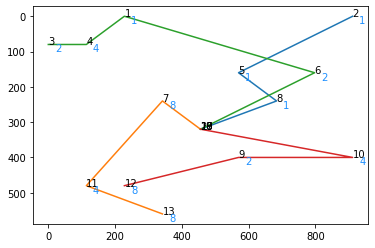

Maximum of the route distances: 936m


In [148]:
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    # argument: (num of total locations including depot(출발지, 종점), num of vehicles, node of depot)
    # geek -> 상점 수, 드라이버 수, hub의 node
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    # geek -> 실제 상점 간 거리 (교통 상황 반영되어야 함.)
    # geek -> 각 node에서 적재하는 데 걸리는 시간 보정 필요
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
         # + data['service_time'][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance -> geek: max time per vehicle로 변경
        True,  # start cumul to zero -> geek: Don't force start cumul to zero.??
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Add Order constraint.
    def order_callback(from_index):
        """Returns the num of orders of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['orders'][from_node]

    order_callback_index = routing.RegisterUnaryTransitCallback(
        order_callback)

    routing.AddDimensionWithVehicleCapacity(
        order_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # routing.AddWeightedVariableTargetToFinalizer()
    # routing.AddWeightedVariableMaximizedByFinalizer()
    # routing.AddWeightedVariableMinimizedByFinalizer()

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # search_parameters.local_search_metaheuristic = (
    #     routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    # search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print('No solution found !')

main()